In [ ]:
from bs4 import BeautifulSoup
import requests
import json
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!pip install cupy-cuda101
import cupy as cp

# Load dict

In [ ]:
dict_url = 'https://firebasestorage.googleapis.com/v0/b/ysc-kme-25095.appspot.com/o/Dict_segment.json?alt=media&token=65014357-fe20-4d0b-8e81-cd0ca5be04ca'
dict_cut_url = 'https://firebasestorage.googleapis.com/v0/b/ysc-kme-25095.appspot.com/o/Dict_segment_cut.json?alt=media&token=f0fe1898-76df-4708-a7c1-ca41397b4152'
dict_ciid_url = 'https://firebasestorage.googleapis.com/v0/b/ysc-kme-25095.appspot.com/o/Dict_segment_ciid.json?alt=media&token=830017dd-28af-4d85-9545-c00f8ac3d3f6'

with requests.Session() as req:
  resp = req.get(dict_url)
  dict_ = resp.json()

with requests.Session() as req:
  resp = req.get(dict_cut_url)
  dict_cut = resp.json()

with requests.Session() as req:
  resp = req.get(dict_ciid_url)
  dict_ciid = resp.json()

# Main

In [ ]:
def write_log(compound):
  with open('log.txt','a') as text_file:
    text_file.write(compound+'\n')

In [ ]:
def concat_dataset(dataset, compound):
  if dataset.shape[0] == 0:
    return compound
  else:
    return cp.concatenate((dataset, compound), axis=0)

## Add img (request url & image)

In [ ]:
def add_img(dataset, path, key, ciid, compound, compound_cut, save_img = False):
  compound_name = compound.replace(' ', '%20')

  html_page = 'https://pubchem.ncbi.nlm.nih.gov/compound/'+ciid+'#section=2D-Structure&fullscreen=true'
  while True:
    try:
      with requests.Session() as html_req:
        html_resp = html_req.get(html_page)
        if html_resp.status_code == 404:
          print(compound, compound_cut,'not found')
          return 1, dataset
        html = BeautifulSoup(html_resp.text, 'html.parser')
                  
        img_tag = html.find("meta", attrs={'property': "og:image"})['content']
        
        with requests.Session() as pic_req:
          pic_resp = pic_req.get(img_tag)
          image = np.asarray(bytearray(pic_resp.content), dtype='uint8')
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
        
        if save_img:
          Image.fromarray(image).save(path+key+'/'+compound.replace(' ','_')+'.jpg')
            
        dataset = concat_dataset(dataset, cp.array(image.reshape(1, 224, 224, 3)))
        return 0, dataset
    except Exception as e:
      print(compound, compound_cut)
      print(e)
      continue
    break

## Run function

In [ ]:
folder_path = 'kme_datasets/'
count = 0
total = 0
total_loss = 0
dataset = cp.array([])

for key in dict_.keys():
  if not os.path.exists(folder_path+key):
    os.makedirs(folder_path+key)
  for i in range(len(dict_[key])):
    plus, dataset = add_img(dataset, folder_path, key, dict_ciid[key][i], dict_[key][i], dict_cut[key][i])
    count += plus

  print(dataset.shape)
  print('-'*25)
  print(key,'loss:',plus,'from:',len(dict_[key]))
  print('-'*25)
  total_loss += count
  total += len(dict_[key])
  count -= count

print("Total loss",total_loss,"from",total)

(10, 224, 224, 3)
-------------------------
alkane loss: 0 from: 10
-------------------------
(38, 224, 224, 3)
-------------------------
alkane_alkyl loss: 0 from: 28
-------------------------
(46, 224, 224, 3)
-------------------------
cyclo_alkane loss: 0 from: 8
-------------------------
(61, 224, 224, 3)
-------------------------
cyclo_alkane_alkyl loss: 0 from: 15
-------------------------
(86, 224, 224, 3)
-------------------------
alkene loss: 0 from: 25
-------------------------
(96, 224, 224, 3)
-------------------------
alkene_alkyl loss: 0 from: 10
-------------------------
(165, 224, 224, 3)
-------------------------
dialkene loss: 0 from: 69
-------------------------
(173, 224, 224, 3)
-------------------------
cyclo_alkene loss: 0 from: 8
-------------------------
(175, 224, 224, 3)
-------------------------
cyclo_alkene_alkyl loss: 0 from: 2
-------------------------
(184, 224, 224, 3)
-------------------------
alkyne loss: 0 from: 9
-------------------------
(188, 224,

In [ ]:
cp.save("kme_dataset.npy", dataset)

# Uncomment if you use colab and mount google drive
#cp.save("/content/drive/My Drive/kme_dataset.npy", dataset)

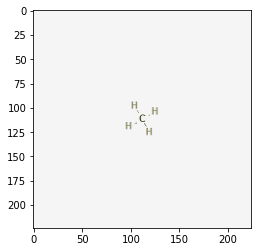

In [ ]:
import matplotlib.pyplot as plt

dataset_import = np.load('/content/drive/My Drive/kme_dataset.npy')
plt.imshow(dataset_import[0]);